In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import cellxgene_census
import rapids_singlecell as rsc
import scib_metrics

## Our random subset

In [3]:
adata_us = sc.read_h5ad('./done_us_czi_subsets/MvxRPxlwLl0LoHCVqaxO.h5ad')

/home/cachris/.conda/envs/sc-env2/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [4]:
adata_us

AnnData object with n_obs × n_vars = 572737 × 36601
    obs: 'srx', 'bare_code', 'nCount_RNACZI', 'nFeature_RNACZI', 'age_groupCZI', 'cell_sourceCZI', 'cell_statesCZI', 'sampleCZI', 'age.orderCZI', 'age.days.GACZI', 'size.CRLCZI', 'size.NRLCZI', 'stageCZI', 'integration.groupsCZI', 'integrated_snn_res.0.1CZI', 'clusters.low.resCZI', 'clusters.high.resCZI', 'clusters.res.2CZI', 'clusters.res.3CZI', 'conditionCZI', 'organism_ontology_term_idCZI', 'tissue_ontology_term_idCZI', 'assay_ontology_term_idCZI', 'disease_ontology_term_idCZI', 'cell_type_ontology_term_idCZI', 'self_reported_ethnicity_ontology_term_idCZI', 'development_stage_ontology_term_idCZI', 'sex_ontology_term_idCZI', 'donor_idCZI', 'suspension_typeCZI', 'is_primary_dataCZI', 'tissue_typeCZI', 'cell_typeCZI', 'assayCZI', 'diseaseCZI', 'organismCZI', 'sexCZI', 'tissueCZI', 'self_reported_ethnicityCZI', 'development_stageCZI', 'observation_joinidCZI', 'clean_name', 'sample', 'CelltypesCZI', 'Loc_trueCZI', 'scsnCZI', 'GenderCZI'

In [5]:
adata_us.obs_names_make_unique()

## Get corresponding CZI data

In [6]:
with cellxgene_census.open_soma() as census:
    adata = cellxgene_census.get_anndata(
        census = census,
        organism = "Homo sapiens",
        obs_value_filter =f"observation_joinid  in {list(adata_us.obs['observation_joinidCZI'].astype(str).values)}",
        column_names = {"obs": ["assay", "cell_type", "tissue", "tissue_general", "suspension_type", "disease", 'dataset_id']},
    )
    print(adata)

The "stable" release is currently 2025-01-30. Specify 'census_version="2025-01-30"' in future calls to open_soma() to ensure data consistency.
/tmp/ipykernel_318775/3706719386.py:2: FutureWarning: The argument `column_names` is deprecated and will be removed in a future release. Please use `obs_column_names` and `var_column_names` instead.
  adata = cellxgene_census.get_anndata(


AnnData object with n_obs × n_vars = 1398331 × 61888
    obs: 'assay', 'cell_type', 'tissue', 'tissue_general', 'suspension_type', 'disease', 'dataset_id', 'observation_joinid'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_type', 'feature_length', 'nnz', 'n_measured_obs'


In [7]:
adata.obs['observation_joinid'].value_counts()

observation_joinid
OyZ6>DrsgA    4
h)8viDRn4G    4
ToRg-vLr2<    4
Q^~fDgpW~z    4
6y5NCp=;=l    4
             ..
`m@V5O-45H    1
z7@J9r^`b{    1
!6HK6P}ill    1
rS?yml96zP    1
WO*h3g|-1m    1
Name: count, Length: 566206, dtype: int64

The cellXgene joinids are somehow not unique??!!? So I use id + cell_type to make sure our cells are the same

In [8]:
adata.obs['unique_join'] = adata.obs['observation_joinid'].astype(str) + adata.obs['cell_type'].astype(str)
adata_us.obs['unique_join'] = adata_us.obs['observation_joinidCZI'].astype(str) + adata_us.obs['cell_typeCZI'].astype(str)
adata = adata[adata.obs.drop_duplicates(subset=['unique_join'], keep='first').index]
adata_us = adata_us[adata_us.obs.drop_duplicates(subset=['unique_join'], keep='first').index]
adata_us = adata_us[adata_us.obs['unique_join'].isin(adata.obs['unique_join'])]
adata = adata[adata.obs['unique_join'].isin(adata_us.obs['unique_join'])]

In [9]:
adata_us.obs['unique_join'].value_counts()

unique_join
^R*%v_#hJvtype II muscle cell               1
7+R#i9*M5jcapillary endothelial cell        1
b096oq7OZfmyeloid cell                      1
$ClGxSYyv+cardiac muscle cell               1
yzg3e&_XJ4mesothelial cell of epicardium    1
                                           ..
1!C;fxP{N5myeloid cell                      1
w`GO8c_FBHendothelial cell                  1
f<4%OW4Ut&myeloid cell                      1
AuzkL0-JV4endothelial cell                  1
u*QGpdlX~~smooth muscle cell                1
Name: count, Length: 566224, dtype: int64

In [10]:
adata_us

View of AnnData object with n_obs × n_vars = 566224 × 36601
    obs: 'srx', 'bare_code', 'nCount_RNACZI', 'nFeature_RNACZI', 'age_groupCZI', 'cell_sourceCZI', 'cell_statesCZI', 'sampleCZI', 'age.orderCZI', 'age.days.GACZI', 'size.CRLCZI', 'size.NRLCZI', 'stageCZI', 'integration.groupsCZI', 'integrated_snn_res.0.1CZI', 'clusters.low.resCZI', 'clusters.high.resCZI', 'clusters.res.2CZI', 'clusters.res.3CZI', 'conditionCZI', 'organism_ontology_term_idCZI', 'tissue_ontology_term_idCZI', 'assay_ontology_term_idCZI', 'disease_ontology_term_idCZI', 'cell_type_ontology_term_idCZI', 'self_reported_ethnicity_ontology_term_idCZI', 'development_stage_ontology_term_idCZI', 'sex_ontology_term_idCZI', 'donor_idCZI', 'suspension_typeCZI', 'is_primary_dataCZI', 'tissue_typeCZI', 'cell_typeCZI', 'assayCZI', 'diseaseCZI', 'organismCZI', 'sexCZI', 'tissueCZI', 'self_reported_ethnicityCZI', 'development_stageCZI', 'observation_joinidCZI', 'clean_name', 'sample', 'CelltypesCZI', 'Loc_trueCZI', 'scsnCZI', 'Ge

In [11]:
adata

View of AnnData object with n_obs × n_vars = 566224 × 61888
    obs: 'assay', 'cell_type', 'tissue', 'tissue_general', 'suspension_type', 'disease', 'dataset_id', 'observation_joinid', 'unique_join'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_type', 'feature_length', 'nnz', 'n_measured_obs'

Now they have the same cells

Because I got my annotations from the CZI collections, which have the CZI author metadata, the tissue labels do not match perfectly.  

In [12]:
adata_us.obs = pd.merge(adata.obs, adata_us.obs, left_on='unique_join', right_on='unique_join', how = 'right')

I do a very basic pre-processing and normalization.  I am not trying to do any strict cell filtering, but just want to do the bare minimum filtering so that the UMAP and PCA work

In [13]:
adata = adata.copy()

In [14]:
rsc.get.anndata_to_GPU(adata)
rsc.pp.filter_cells(adata, min_count = 100, qc_var='n_genes_by_counts')
rsc.pp.filter_genes(adata, min_count = 40)
rsc.pp.normalize_total(adata)
rsc.pp.log1p(adata)
rsc.get.anndata_to_CPU(adata)
sc.pp.pca(adata)
rsc.get.anndata_to_GPU(adata)
rsc.pp.neighbors(adata)
rsc.tl.umap(adata)

Running `calculate_qc_metrics` for 'n_cells_by_counts' or 'total_counts'
filtered out 198 cells
filtered out 33139 genes based on n_cells_by_counts


In [15]:
adata_us = adata_us.copy()

/home/cachris/.conda/envs/sc-env2/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [16]:
rsc.get.anndata_to_GPU(adata_us)
rsc.pp.filter_cells(adata_us, min_count = 100, qc_var='n_genes_by_counts')
rsc.pp.filter_genes(adata_us, min_count = 40)
rsc.pp.normalize_total(adata_us)
rsc.pp.log1p(adata_us)
rsc.get.anndata_to_CPU(adata_us)
sc.pp.pca(adata_us)
rsc.get.anndata_to_GPU(adata_us)
rsc.pp.neighbors(adata_us)
rsc.tl.umap(adata_us)

Running `calculate_qc_metrics` for 'n_cells_by_counts' or 'total_counts'
filtered out 10584 cells
filtered out 5799 genes based on n_cells_by_counts


/home/cachris/.conda/envs/sc-env2/lib/python3.12/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/cachris/.conda/envs/sc-env2/lib/python3.12/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


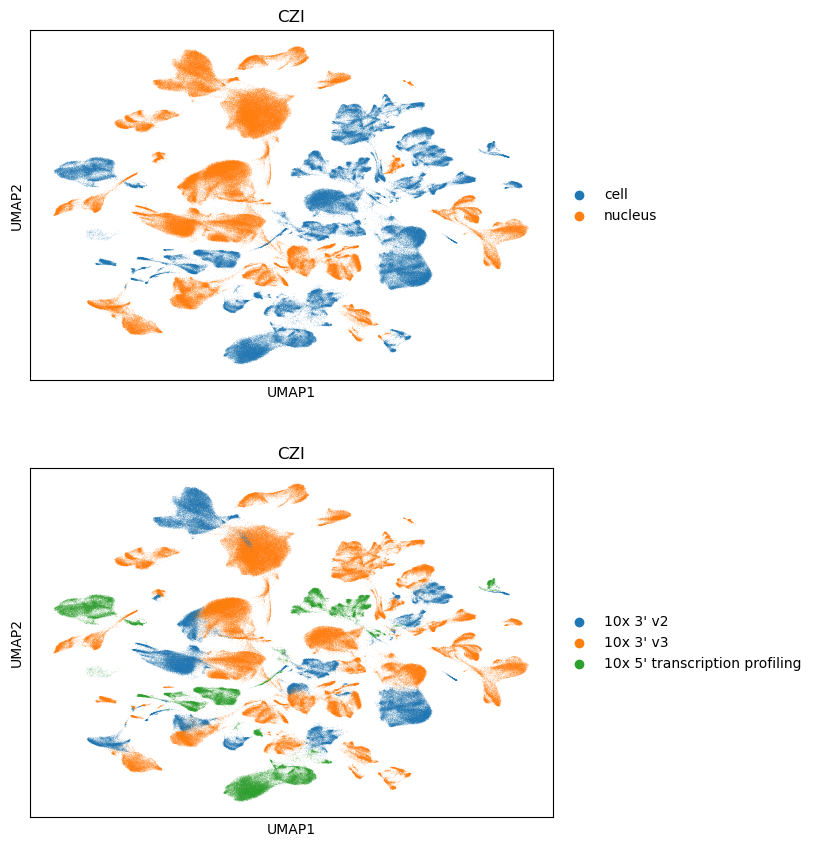

In [17]:
sc.pl.umap(adata[adata.obs['unique_join'].isin(adata_us.obs['unique_join'].values)], color = ['suspension_type', 'assay'], title = ['CZI', 'CZI'], ncols=1)

In [18]:
sc.pl.umap(adata_us[adata_us.obs['unique_join'].isin(adata.obs['unique_join'].values)], color = ['suspension_typeCZI', 'assayCZI'], title = ['Us', 'Us'], ncols=1)

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

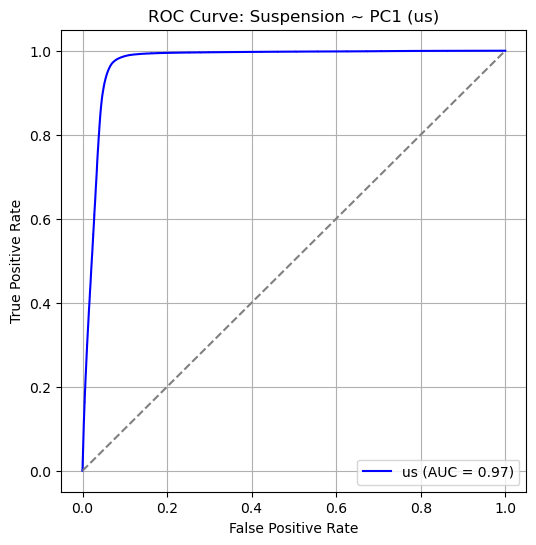

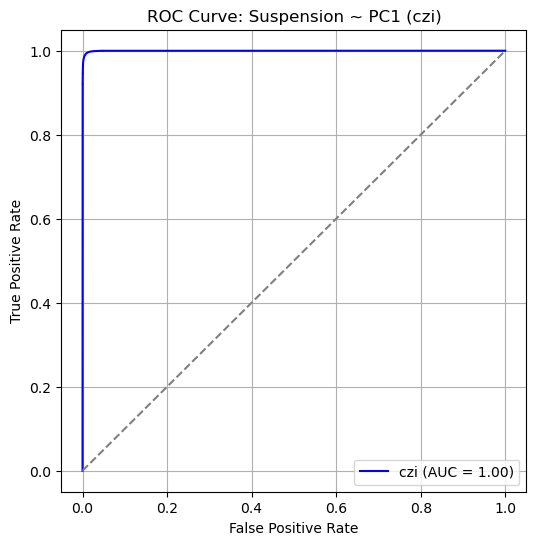

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Function to compute and plot ROC curve for a given AnnData object
def plot_roc_curve(adata, group_label):
    pc1 = adata.obsm["X_pca"][:, 0]  # First principal component (PC1)
    
    # One-hot encode suspension_type
    suspension_encoded = pd.get_dummies(adata.obs["suspension_type"], prefix="suspension")

    # Choose one of the suspension types as the target variable (modify as needed)
    suspension = suspension_encoded.iloc[:, 0]  # Use first encoded column

    # Create DataFrame
    df = pd.DataFrame({"PC1": pc1, "suspension": suspension})

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(df["suspension"], df["PC1"])
    roc_auc = auc(fpr, tpr)

    # Create plot
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f"{group_label} (AUC = {roc_auc:.2f})", color="blue")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal reference line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve: Suspension ~ PC1 ({group_label})")
    plt.legend()
    plt.grid()

    # Save and show the plot
    plt.savefig(f"roc_suspension_pc1_{group_label}.pdf", bbox_inches="tight", dpi=300)
    plt.show()

# Generate ROC plots for both datasets
plot_roc_curve(adata_us, "us")
plot_roc_curve(adata, "czi")


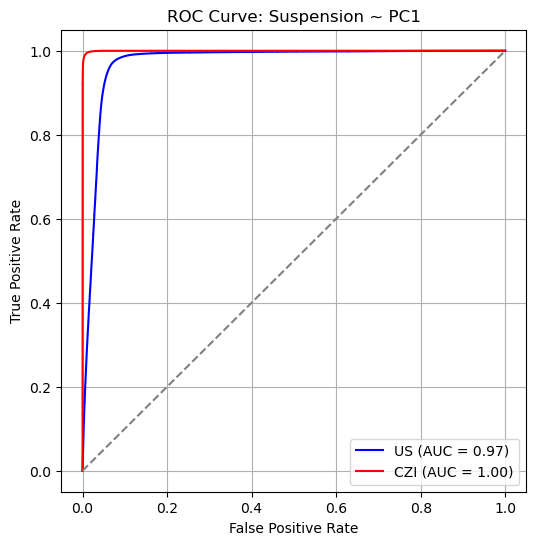

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Function to compute ROC curve data
def compute_roc_data(adata):
    pc1 = adata.obsm["X_pca"][:, 0]  # First principal component (PC1)

    # One-hot encode suspension_type
    suspension_encoded = pd.get_dummies(adata.obs["suspension_type"], prefix="suspension")

    # Choose one of the suspension types as the target variable (modify as needed)
    suspension = suspension_encoded.iloc[:, 0]  # Use first encoded column

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(suspension, pc1)
    roc_auc = auc(fpr, tpr)
    
    return fpr, tpr, roc_auc

# Compute ROC data for both groups
fpr_us, tpr_us, auc_us = compute_roc_data(adata_us)
fpr_czi, tpr_czi, auc_czi = compute_roc_data(adata)

# Plot ROC curves together
plt.figure(figsize=(6, 6))

plt.plot(fpr_us, tpr_us, label=f"US (AUC = {auc_us:.2f})", color="blue")
plt.plot(fpr_czi, tpr_czi, label=f"CZI (AUC = {auc_czi:.2f})", color="red")

# Reference diagonal
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

# Labels and title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Suspension ~ PC1")
plt.legend()
plt.grid()

# Save and show the plot
plt.savefig("roc_suspension_pc1_combined.pdf", bbox_inches="tight", dpi=300)
plt.show()


/tmp/ipykernel_299551/892609518.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=auc_df, x="Group", y="AUC", palette=["blue", "red"])


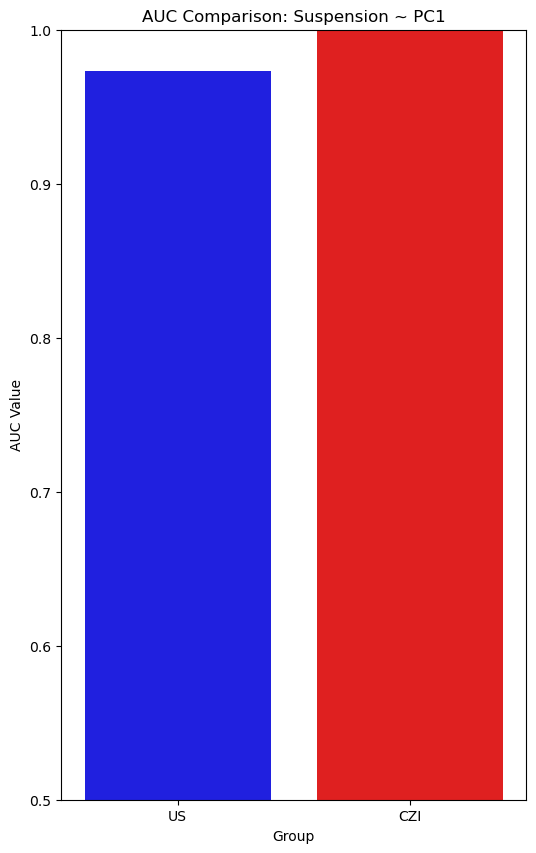

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import seaborn as sns

# Function to compute AUC
def compute_auc(adata):
    pc1 = adata.obsm["X_pca"][:, 0]  # First principal component (PC1)
    
    # One-hot encode suspension_type
    suspension_encoded = pd.get_dummies(adata.obs["suspension_type"], prefix="suspension")

    # Choose one of the suspension types as the target variable (modify if needed)
    suspension = suspension_encoded.iloc[:, 0]  # Use first encoded column
    
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(suspension, pc1)
    roc_auc = auc(fpr, tpr)
    
    return roc_auc

# Compute AUC values
auc_us = compute_auc(adata_us)
auc_czi = compute_auc(adata)

# Create a DataFrame for plotting
auc_df = pd.DataFrame({"Group": ["US", "CZI"], "AUC": [auc_us, auc_czi]})

# Plot bar chart
plt.figure(figsize=(6, 10))
sns.barplot(data=auc_df, x="Group", y="AUC", palette=["blue", "red"])

# Labels and title
plt.ylabel("AUC Value")
plt.title("AUC Comparison: Suspension ~ PC1")
plt.ylim(0.5, 1)  # AUC ranges from 0 to 1

# Save and show plot
plt.savefig("auc_comparison_bar.pdf", dpi=300)
plt.show()


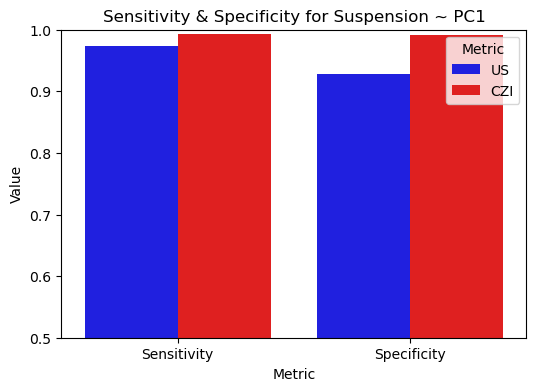

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# Function to compute Sensitivity and Specificity
def compute_sensitivity_specificity(adata):
    pc1 = adata.obsm["X_pca"][:, 0]  # First principal component (PC1)
    
    # One-hot encode suspension_type
    suspension_encoded = pd.get_dummies(adata.obs["suspension_type"], prefix="suspension")

    # Choose one of the suspension types as the target variable (modify if needed)
    suspension = suspension_encoded.iloc[:, 0]  # Use first encoded column

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(suspension, pc1)

    # Compute Specificity (1 - FPR)
    specificity = 1 - fpr

    # Find best threshold using Youden’s J statistic (J = Sensitivity + Specificity - 1)
    youden_index = np.argmax(tpr + specificity - 1)
    best_sensitivity = tpr[youden_index]
    best_specificity = specificity[youden_index]
    
    return best_sensitivity, best_specificity

# Compute values for both groups
sens_us, spec_us = compute_sensitivity_specificity(adata_us)
sens_czi, spec_czi = compute_sensitivity_specificity(adata)

# Create DataFrame for plotting
data = pd.DataFrame({
    "Group": ["US", "US", "CZI", "CZI"],
    "Metric": ["Sensitivity", "Specificity", "Sensitivity", "Specificity"],
    "Value": [sens_us, spec_us, sens_czi, spec_czi]
})

# Plot bar chart
plt.figure(figsize=(6, 4))
sns.barplot(data=data, x="Metric", y="Value", hue="Group", palette=["blue", "red"])

# Labels and title
plt.ylabel("Value")
plt.title("Sensitivity & Specificity for Suspension ~ PC1")
plt.ylim(0.5, 1)  # Values range from 0 to 1
plt.legend(title="Metric")

# Save and show plot
plt.savefig("sensitivity_specificity_bar.pdf", bbox_inches="tight", dpi=300)
plt.show()


Now look at PCA

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
adata_us

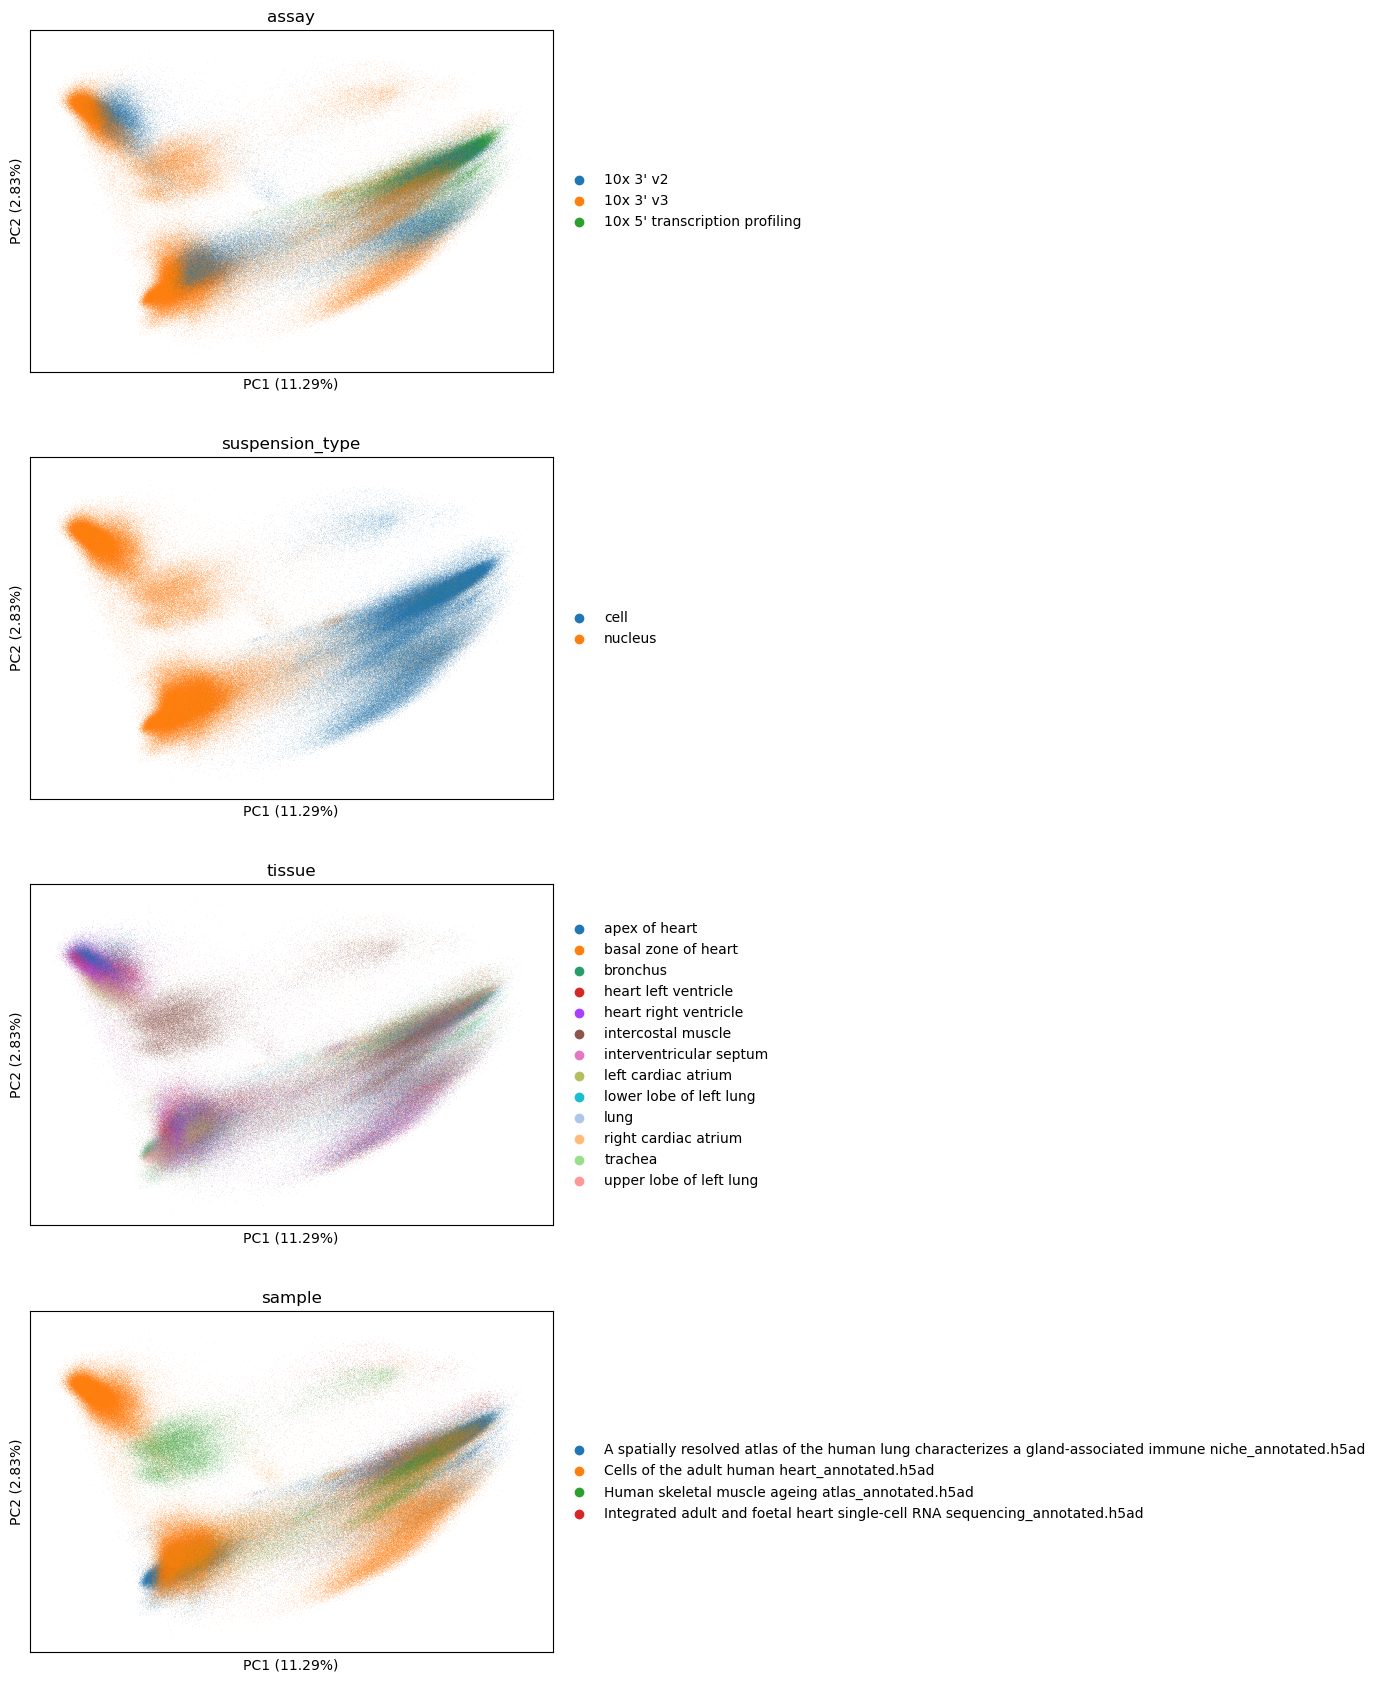

In [ ]:
sc.pl.pca(adata_us, color = ['assayCZI', 'suspension_typeCZI', 'tissueCZI', 'sample'], title = ['assay', 'suspension_type', 'tissue', 'sample'], ncols = 1, annotate_var_explained = True, save='PCA_us.png')

In [ ]:
adata_us.obs['sample'] = adata_us.obs['sample'].str.split('/').str[-1]

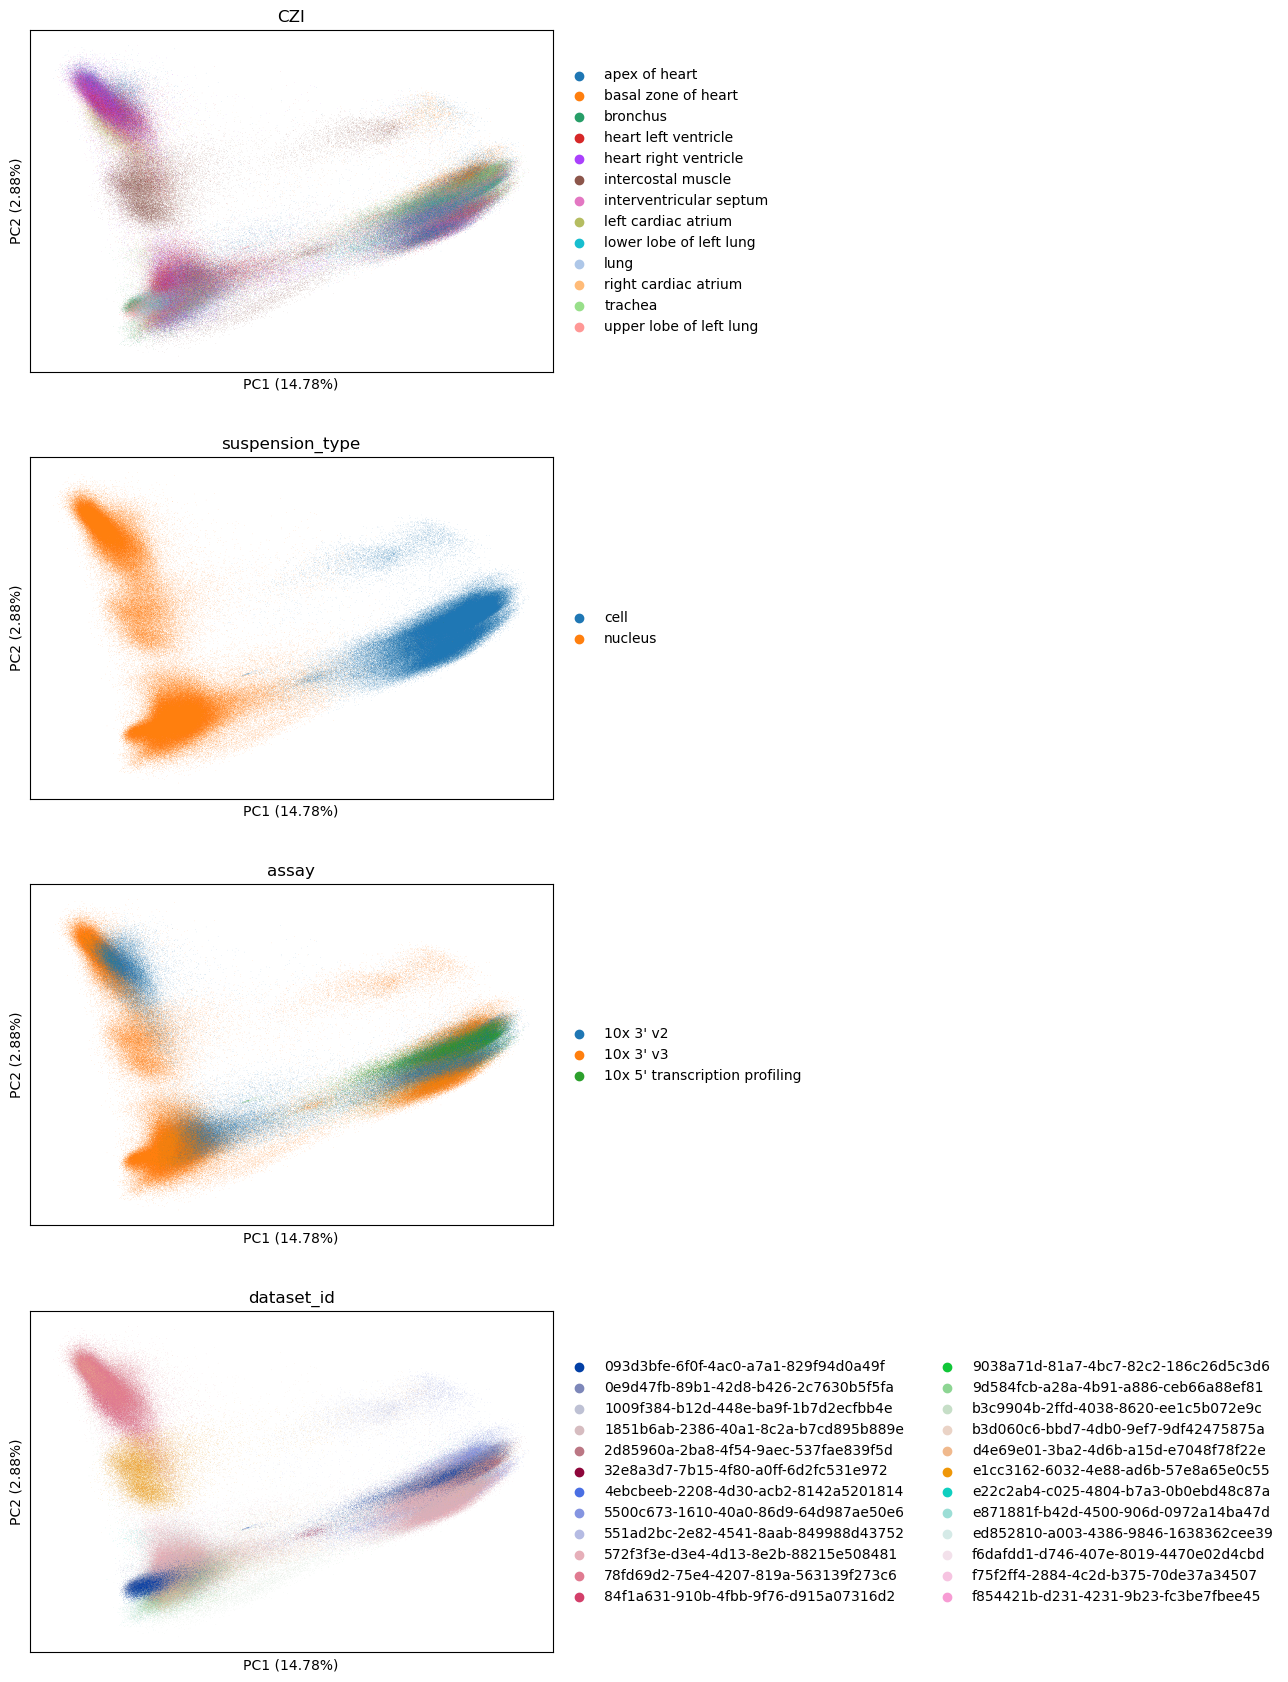

In [ ]:
sc.pl.pca(adata, color = [ 'tissue', 'suspension_type', 'assay', 'dataset_id'], title = ['CZI'], annotate_var_explained=True, ncols = 1, save='czi_tissue_pca.png')

Save as pdfs

FileNotFoundError: [Errno 2] No such file or directory: 'figures3B_2/us_tissueCZI_pca.pdf'

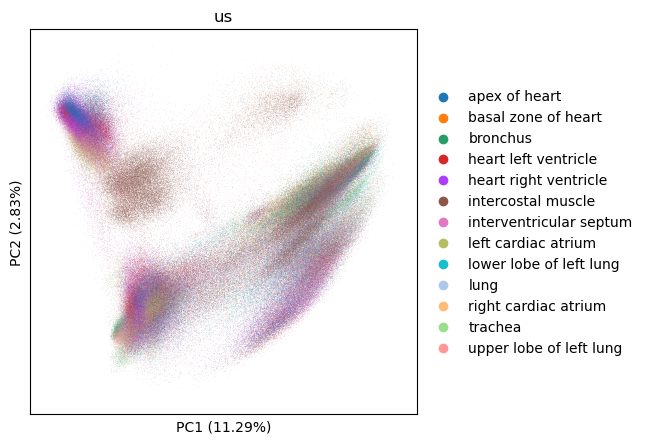

In [ ]:
for source in ['us', 'czi']:
        for variable in ['tissue', 'suspension_type', 'assay']:
                ad = adata
                if source == 'us':
                        ad = adata_us
                        variable = variable + 'CZI'
                fig, ax = plt.subplots(figsize=(5, 5))
                sc.pl.pca(
                ad, 
                color=variable,
                title=source, 
                annotate_var_explained=True, 
                ncols=1, 
                save=False,  # Don't auto-save yet
                ax=ax,
                show=False
                )
                for artist in ax.collections:
                        artist.set_rasterized(True)
                # Save as a rasterized PDF
                plt.savefig(f"figures3B_2/{source}_{variable}_pca.pdf", format="pdf", dpi=300,  bbox_inches="tight")
                plt.close()

Compute statistics (LISI and silhoutte)

For silhoutte, we use the two PCs in the plot so that our numbers are consistent with the visualization

In [ ]:
results_df = pd.DataFrame()

this is kind of messy, but ...

In [ ]:
sil_us_tissue = scib_metrics.silhouette_label(adata_us.obsm['X_pca'][:,0:2], adata_us.obs['tissueCZI'], rescale=True)
results_df.loc[1, 'metric'] = 'silhoutte'
results_df.loc[1, 'group'] = 'us'
results_df.loc[1, 'variable'] = 'tissue'
results_df.loc[1, 'value'] = sil_us_tissue
sil_us_sus = scib_metrics.silhouette_label(adata_us.obsm['X_pca'][:,0:2], adata_us.obs['suspension_typeCZI'], rescale=True)
results_df.loc[2, 'metric'] = 'silhoutte'
results_df.loc[2, 'group'] = 'us'
results_df.loc[2, 'variable'] = 'suspension'
results_df.loc[2, 'value'] = sil_us_sus
sil_czi_sus = scib_metrics.silhouette_label(adata.obsm['X_pca'][:,0:2], adata.obs['suspension_type'], rescale=True)
results_df.loc[3, 'metric'] = 'silhoutte'
results_df.loc[3, 'group'] = 'czi'
results_df.loc[3, 'variable'] = 'suspension'
results_df.loc[3, 'value'] = sil_czi_sus
sil_czi_tissue = scib_metrics.silhouette_label(adata.obsm['X_pca'][:,0:2], adata.obs['tissue'], rescale=True)
results_df.loc[4, 'metric'] = 'silhoutte'
results_df.loc[4, 'group'] = 'czi'
results_df.loc[4, 'variable'] = 'tissue'
results_df.loc[4, 'value'] = sil_czi_tissue
#nn_us = jax_approx_min_k(adata_us.obsm['X_pca'][:,0:2], 1500)
lisi_us_sus = scib_metrics.clisi_knn(nn_us, adata_us.obs['suspension_typeCZI'], scale=True, perplexity=100)
results_df.loc[5, 'metric'] = 'ILISI'
results_df.loc[5, 'group'] = 'us'
results_df.loc[5, 'variable'] = 'suspension'
results_df.loc[5, 'value'] = lisi_us_sus
lisi_us_tissue = scib_metrics.clisi_knn(nn_us, adata_us.obs['tissueCZI'], scale=True, perplexity=100)
results_df.loc[6, 'metric'] = 'ILISI'
results_df.loc[6, 'group'] = 'us'
results_df.loc[6, 'variable'] = 'tissue'
results_df.loc[6, 'value'] = lisi_us_tissue
#nn_czi = jax_approx_min_k(adata.obsm['X_pca'][:,0:2], 1500)
lisi_czi_sus = scib_metrics.clisi_knn(nn_czi, adata.obs['suspension_type'], scale=True, perplexity=100)
results_df.loc[7, 'metric'] = 'ILISI'
results_df.loc[7, 'group'] = 'czi'
results_df.loc[7, 'variable'] = 'suspension'
results_df.loc[7, 'value'] = lisi_czi_sus
lisi_czi_tissue = scib_metrics.clisi_knn(nn_czi, adata.obs['tissue'], scale=True, perplexity=100)
results_df.loc[8, 'metric'] = 'ILISI'
results_df.loc[8, 'group'] = 'czi'
results_df.loc[8, 'variable'] = 'tissue'
results_df.loc[8, 'value'] = lisi_czi_tissue

In [ ]:
results_df

,metric,group,variable,value,normalized_value
1,silhoutte,us,tissue,0.342024,1.000000
2,silhoutte,us,suspension,0.769881,2.250954
3,silhoutte,czi,suspension,0.852017,2.898677
4,silhoutte,czi,tissue,0.293033,1.000000
5,ILISI,us,suspension,0.954474,1.296111
6,ILISI,us,tissue,0.578574,1.000000
7,ILISI,czi,suspension,1.000000,1.296594
8,ILISI,czi,tissue,0.584905,1.000000


In [ ]:
adata_us.obs['sample'] = adata_us.obs['sample'].str.split('_annotated.h5ad').str[0]

In [ ]:
adata_us.obs['sample'].value_counts()

sample
Cells of the adult human heart                                                                328595
A spatially resolved atlas of the human lung characterizes a gland-associated immune niche    142492
Human skeletal muscle ageing atlas                                                             57581
Integrated adult and foetal heart single-cell RNA sequencing                                   26972
Name: count, dtype: int64

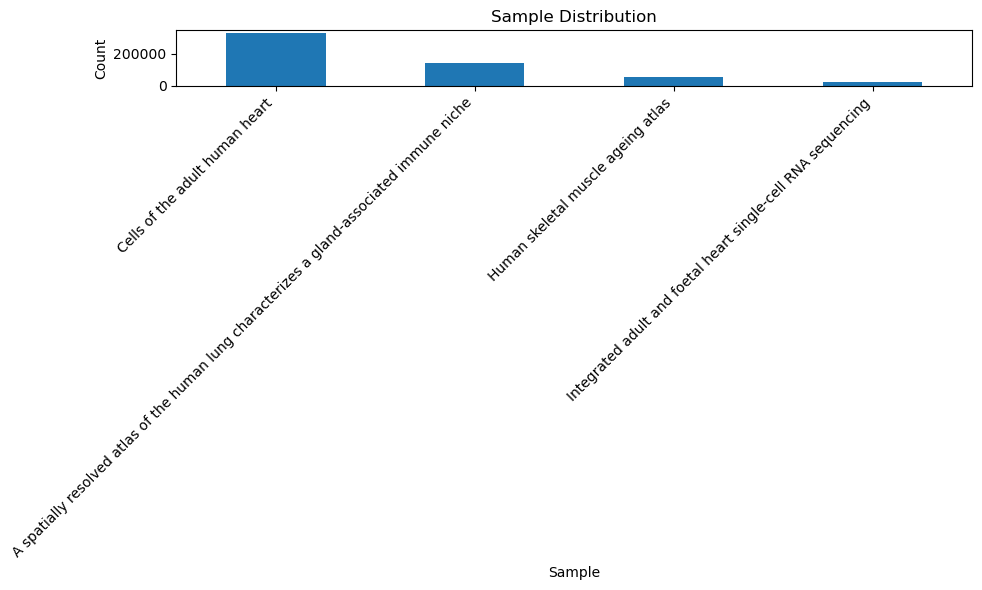

In [ ]:
adata_us.obs.loc[]
ax = adata_us.obs['sample'].value_counts().plot(kind='bar', figsize=(10, 6))

# Tilt the x-axis labels 45 degrees
plt.xticks(rotation=45, ha='right')

# Add labels and title
ax.set_xlabel('Sample')
ax.set_ylabel('Count')
ax.set_title('Sample Distribution')

# Display the plot with proper spacing for tilted labels
plt.tight_layout()
plt.show()

In [ ]:
scib_metrics.ilisi_knn(nn_us, adata_us.obs['suspension_typeCZI'], scale=True, perplexity=15)

0.004152774810791016

In [ ]:
scib_metrics.ilisi_knn(nn_czi, adata.obs['suspension_type'], scale=True, perplexity=15)

0.4817957878112793

In [ ]:
lisi_czi_tissue_c = scib_metrics.clisi_knn(nn_czi, adata.obs['tissue'], scale=True, perplexity=15)
lisi_czi_tissue = scib_metrics.ilisi_knn(nn_czi, adata.obs['tissue'], scale=True, perplexity=15)

In [ ]:
lisi_czi_tissue_c

0.7469297250111898

In [ ]:
lisi_czi_tissue

0.25307027498881024

In [ ]:
results_df

,metric,group,variable,value,normalized_value
1,silhoutte,us,tissue,0.342024,1.000000
2,silhoutte,us,suspension,0.769881,2.250954
3,silhoutte,czi,suspension,0.852017,2.898677
4,silhoutte,czi,tissue,0.293033,1.000000
5,ILISI,us,suspension,0.966167,1.296111
6,ILISI,us,tissue,0.630646,1.000000
7,ILISI,czi,suspension,1.000000,1.296594
8,ILISI,czi,tissue,0.771689,1.000000


In [ ]:


# Get the 'tissue' value for each metric & group combination
tissue_values = results_df[results_df["variable"] == "tissue"].set_index(["metric", "group"])["value"]

# Divide each row's value by the corresponding 'tissue' value
results_df["normalized_value"] = results_df.apply(
    lambda row: row["value"] / tissue_values.get((row["metric"], row["group"]), 1),
    axis=1
)


NameError: name 'results_df' is not defined

In [ ]:
import seaborn as sns

In [ ]:
g.axes[0]

NameError: name 'g' is not defined

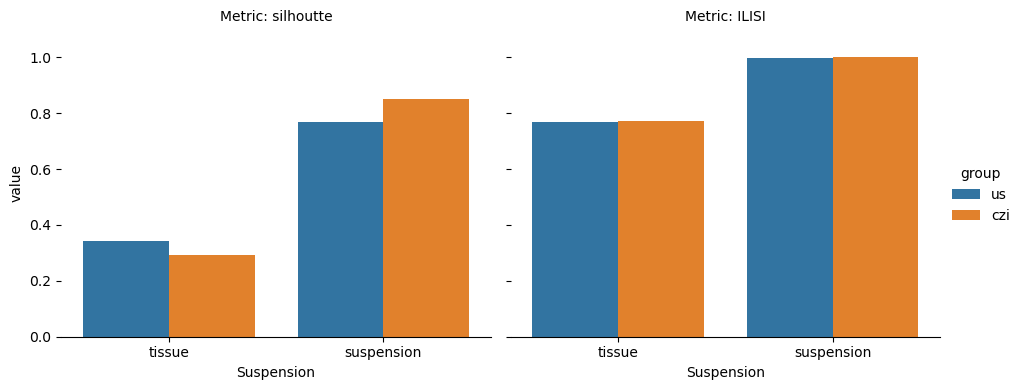

In [ ]:
g = sns.catplot(
    data=results_df,
    x="variable", 
    y="value", 
    hue="group",  # Color by 'group'
    col="metric",  # Facet by 'metric'
    kind="bar", 
    height=4, aspect=1.2,
    
)


# Improve layout
g.set_axis_labels("Suspension")
g.set_titles("Metric: {col_name}")
g.despine(left=True)
for ax in g.axes.flat:
    ax.set_ylim(0, results_df[results_df["metric"] == ax.get_title().split(": ")[1]]["value"].max() * 1.1)  
plt.savefig('3B_silhoutte_tissue.pdf')
plt.show()
plt.show()

In [ ]:
results_df

,metric,group,variable,value,normalized_value
1,silhoutte,us,tissue,3.420241e-01,1.000000
2,silhoutte,us,suspension,7.698809e-01,2.250955
3,silhoutte,czi,suspension,8.519164e-01,2.898676
4,silhoutte,czi,tissue,2.938985e-01,1.000000
5,ILISI,us,suspension,4.152536e-03,0.017924
6,ILISI,us,tissue,2.316710e-01,1.000000
7,ILISI,czi,suspension,7.152557e-07,0.000003
8,ILISI,czi,tissue,2.287454e-01,1.000000


FileNotFoundError: [Errno 2] No such file or directory: './figures3B_2/silhoutte_suspension_unnorm.pdf'

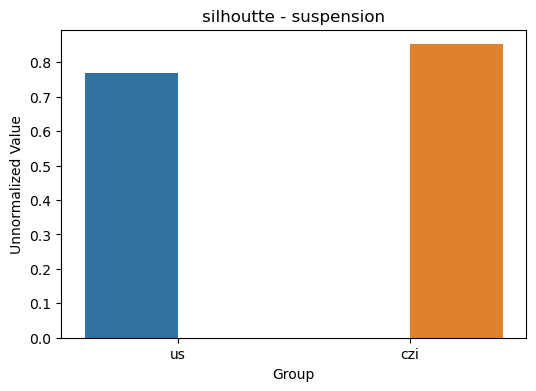

In [ ]:
for metric in ['silhoutte', 'ILISI']:
    for variable in ['suspension', 'tissue']:
        # Filter Data
        subset = results_df[(results_df['metric'] == metric) & (results_df['variable'] == variable)]
        
        # Create Bar Plot with Dodging
        plt.figure(figsize=(6, 4))
        g = sns.barplot(data=subset, x='group', y='value', hue='group', dodge=True)
        
        # Labels and Title
        plt.ylabel("Unnormalized Value")
        plt.xlabel("Group")
        plt.title(f"{metric} - {variable}")
        
        # Save Plot
        plt.savefig(f"./figures3B_2/{metric}_{variable}_unnorm.pdf", bbox_inches="tight", dpi=300)
        
        # Show Plot
        plt.show()


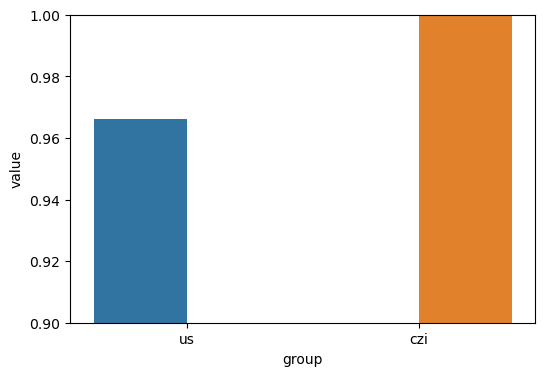

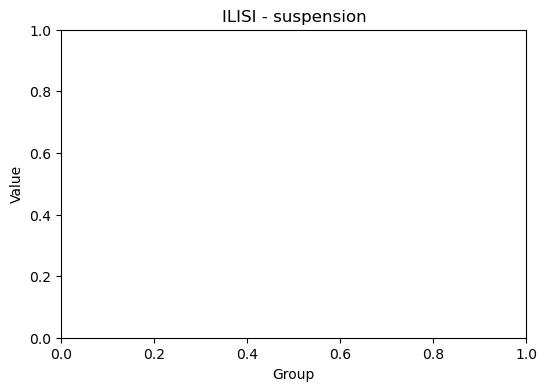

In [ ]:
for metric in ['silhoutte', 'ILISI']:
    for variable in ['suspension', 'tissue']:
        if metric == 'ILISI':
            if variable == 'suspension':
                # Filter Data
                subset = results_df[(results_df['metric'] == metric) & (results_df['variable'] == variable)]
                fig, ax = plt.subplots(figsize=(6, 4))
                # Create Bar Plot with Dodging
                plt.figure(figsize=(6, 4))
                g = sns.barplot(data=subset, x='group', y='value', hue='group', dodge=True, ax=ax)
                
                # Labels and Title
                plt.ylabel("Value")
                plt.xlabel("Group")
                plt.title(f"{metric} - {variable}")
                ax.set_ylim(0.9, 1)
                # Save Plot
            # plt.savefig(f"./figures3B_2/{metric}_{variable}_norm.pdf", bbox_inches="tight", dpi=300)
                
                # Show Plot
                plt.show()

In [ ]:
results_df.to_csv('./figures3B_2/3Bresults.csv')

In [ ]:
nn_us = jax_approx_min_k(adata_us.obsm['X_pca'][:,0:2], 1500)
lisi_us_sus = scib_metrics.ilisi_knn(nn_us, adata_us.obs['suspension_typeCZI'], scale=True, perplexity=800)

In [ ]:
lisi_us_sus = scib_metrics.ilisi_knn(nn_us, adata_us.obs['suspension_typeCZI'], scale=True, perplexity=90)

In [ ]:
lisi_us_sus

0.032351016998291016

In [ ]:
#nn_czi = jax_approx_min_k(adata.obsm['X_pca'][:,0:2], 1500)
lisi_czi_sus = scib_metrics.ilisi_knn(nn_czi, adata.obs['suspension_type'], scale=True, perplexity=90)

In [ ]:
lisi_czi_sus

1.430511474609375e-06

In [ ]:
lisi_us_sus

0.045526742935180664

In [ ]:
adata.write_h5ad('adata_czi.h5ad')
adata_us.write_h5ad('adata_us.h5ad')

In [ ]:
import seaborn as sns

In [ ]:
silhoutte = results_df[results_df['metric'] == 'silhoutte']


In [ ]:
import scib

ModuleNotFoundError: No module named 'scib'

In [ ]:
ilisi = results_df[results_df['metric'] == 'ILISI']
ilisi['log'] = -np.log10(ilisi['value'])

/tmp/ipykernel_299551/108711750.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ilisi['log'] = -np.log10(ilisi['value'])


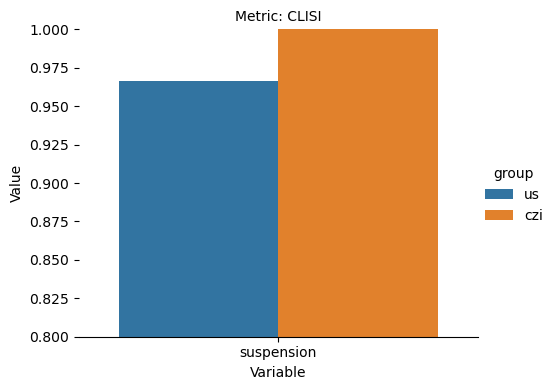

In [ ]:
g = sns.catplot(
    data=ilisi[ilisi['variable'] == 'suspension'],
    x="variable", 
    y="value", 
    hue="group",  # Color by 'group'
    col="metric",  # Facet by 'metric'
    kind="bar", 
    height=4, aspect=1.2
)

# Set y-limit for all subplots in the FacetGrid
g.set(ylim=(0.8, 1))

# Improve layout
g.set_axis_labels("Variable", "Value")
g.set_titles("Metric: CLISI")
g.despine(left=True)
plt.savefig('CLISI_suspension.pdf')

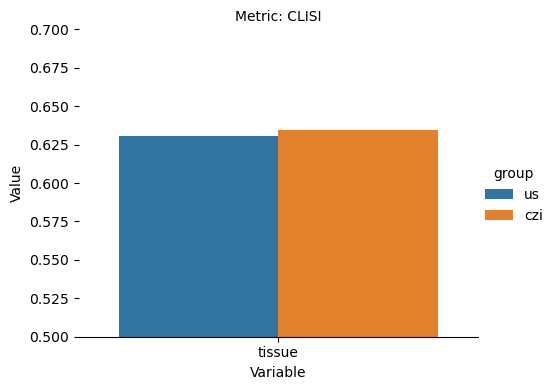

In [ ]:
g = sns.catplot(
    data=ilisi[ilisi['variable'] == 'tissue'],
    x="variable", 
    y="value", 
    hue="group",  # Color by 'group'
    col="metric",  # Facet by 'metric'
    kind="bar", 
    height=4, aspect=1.2
)

# Set y-limit for all subplots in the FacetGrid
g.set(ylim=(0.5, 0.7))

# Improve layout
g.set_axis_labels("Variable", "Value")
g.set_titles("Metric: CLISI")
g.despine(left=True)
plt.savefig('CLISI_tissue.pdf')

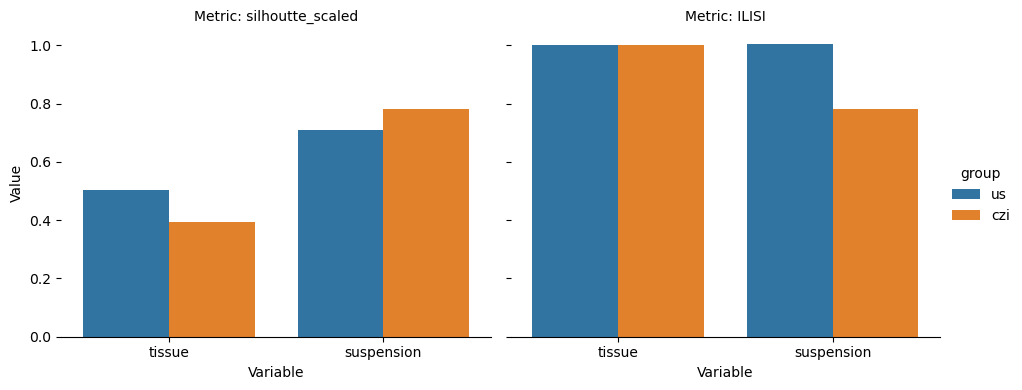

In [ ]:
g = sns.catplot(
    data=results_df,
    x="variable", 
    y="value", 
    hue="group",  # Color by 'group'
    col="metric",  # Facet by 'metric'
    kind="bar", 
    height=4, aspect=1.2
)

# Improve layout
g.set_axis_labels("Variable", "Value")
g.set_titles("Metric: {col_name}")
g.despine(left=True)

plt.show()

In [ ]:
import scib_metrics
import pandas as pd
import os

import functools

import jax
import jax.numpy as jnp
import numpy as np

from scib_metrics.utils import cdist, get_ndarray
from scib_metrics.nearest_neighbors import  NeighborsResults
import scanpy as sc
import numpy as np
from scib_metrics.nearest_neighbors import NeighborsResults


@functools.partial(jax.jit, static_argnames=["k", "recall_target"])
def _euclidean_ann(qy: jnp.ndarray, db: jnp.ndarray, k: int, recall_target: float = 0.95):
    """Compute half squared L2 distance between query points and database points."""
    dists = cdist(qy, db)
    return jax.lax.approx_min_k(dists, k=k, recall_target=recall_target)



def jax_approx_min_k(
    X: np.ndarray, n_neighbors: int, recall_target: float = 0.95, chunk_size: int = 2048
) -> NeighborsResults:
    """Run approximate nearest neighbor search using jax.

    On TPU backends, this is approximate nearest neighbor search. On other backends, this is exact nearest neighbor search.

    Parameters
    ----------
    X
        Data matrix.
    n_neighbors
        Number of neighbors to search for.
    recall_target
        Target recall for approximate nearest neighbor search.
    chunk_size
        Number of query points to search for at once.
    """
    db = jnp.asarray(X)
    # Loop over query points in chunks
    neighbors = []
    dists = []
    for i in range(0, db.shape[0], chunk_size):
        start = i
        end = min(i + chunk_size, db.shape[0])
        qy = db[start:end]
        dist, neighbor = _euclidean_ann(qy, db, k=n_neighbors, recall_target=recall_target)
        neighbors.append(neighbor)
        dists.append(dist)
    neighbors = jnp.concatenate(neighbors, axis=0)
    dists = jnp.concatenate(dists, axis=0)
    return NeighborsResults(indices=get_ndarray(neighbors), distances=get_ndarray(dists))

In [1]:
from scipy.stats import wasserstein_distance_nd

In [22]:
wasserstein_distance_nd(adata.obsm['X_pca'][:,0:10][adata.obs['suspension_type'] =='nucleus'], adata.obsm['X_pca'][:,0:10][adata.obs['suspension_type'] =='cell'])

In [19]:
from scipy.stats import wasserstein_distance
wasserstein_distance(adata.obsm['X_pca'][:,0][adata.obs['suspension_type'] =='nucleus'], adata.obsm['X_pca'][:,0][adata.obs['suspension_type'] =='cell'])

22.249961160894305

In [20]:
wasserstein_distance(adata_us.obsm['X_pca'][:,0][adata_us.obs['suspension_typeCZI'] =='nucleus'], adata_us.obsm['X_pca'][:,0][adata_us.obs['suspension_typeCZI'] =='cell'])

19.35839377555339